## Calling the Data Reader Class

In [58]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

WIDERFACE data is read!

## Drawing a Ground Truth Image

In [83]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(wf_path * "train/images/" * file_name, 640, r=train_reader, boxes=d.bboxes[file_name])
print("Image file is read: ", file_name, '\n')

Image file is read: 22--Picnic/22_Picnic_Picnic_22_231.jpg


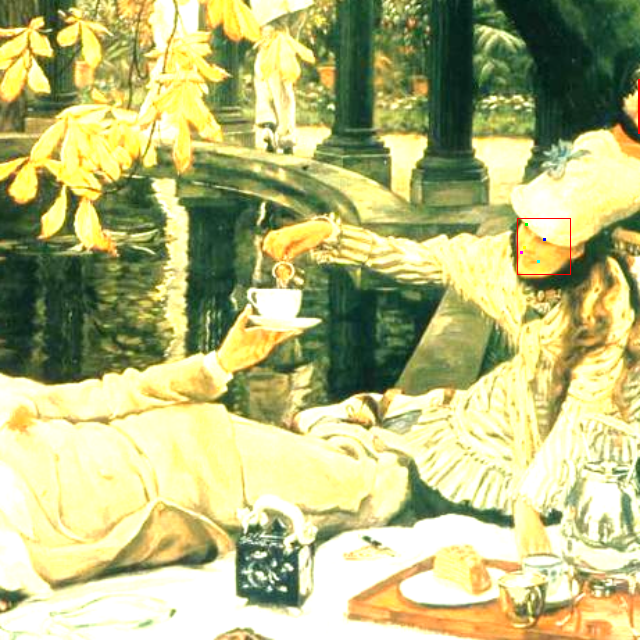

In [84]:
include("./BBTNet/utils/draw.jl")

img = convert(Array{Float32}, img .+ avg_img)
img ./= 255

draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

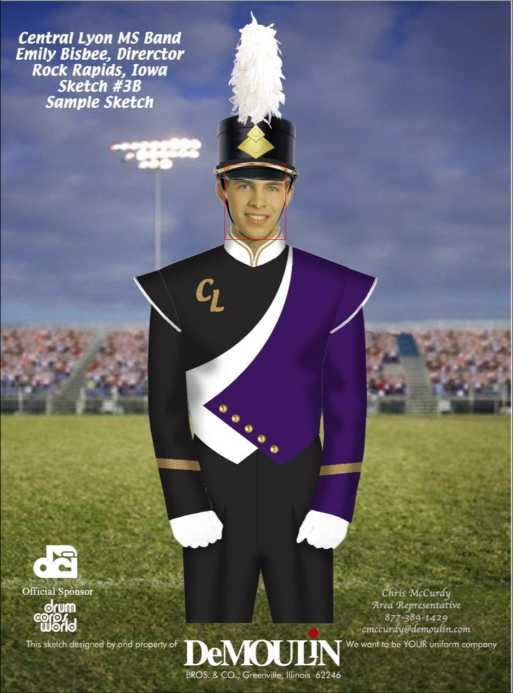

In [85]:
using Images

include("./BBTNet/utils/draw.jl")

d = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, d)

## Loading & Saving a Model

In [87]:
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
print("Model is loaded from a file!\n")

Model is loaded from a file!


In [89]:
file_name = "dummy_path.jld2"
save_model(model, save_dir * file_name)
print("Model is saved to:", save_dir * file_name, "\n")

Model is saved to:./weights/dummy_path.jld2


## Training the Model

In [1]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

batch_size = 2

d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)

model = RetinaFace(dtype=atype)
train_model(model, d, save_dir=save_dir)


--- Epoch: 1 & Batch: 0/12880

Total Loss: 44.180 | Cls Loss: 1.1300 | Box Loss: 4.9640 | Point Loss: 27.978 | Decay: 5.1450
Total Loss: 29.813 | Cls Loss: 1.1550 | Box Loss: 3.4150 | Point Loss: 16.683 | Decay: 5.1460
Total Loss: 29.505 | Cls Loss: 1.0910 | Box Loss: 3.4360 | Point Loss: 16.394 | Decay: 5.1480
Total Loss: 27.486 | Cls Loss: 1.0810 | Box Loss: 2.9340 | Point Loss: 15.386 | Decay: 5.1520
Total Loss: 37.322 | Cls Loss: 1.1070 | Box Loss: 4.0200 | Point Loss: 23.017 | Decay: 5.1570

--- Epoch: 1 & Batch: 10/12880

Total Loss: 32.370 | Cls Loss: 1.1030 | Box Loss: 3.2760 | Point Loss: 19.553 | Decay: 5.1640
Total Loss: 26.523 | Cls Loss: 1.1620 | Box Loss: 2.0750 | Point Loss: 16.038 | Decay: 5.1710
Total Loss: 13.431 | Cls Loss: 1.1640 | Box Loss: 3.5440 | Point Loss: 0.0000 | Decay: 5.1800
Total Loss: 36.318 | Cls Loss: 1.1630 | Box Loss: 4.0280 | Point Loss: 21.911 | Decay: 5.1880


## Testing the Model

#### Testing a Batch

In [2]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=batch_size, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
c, b, l = model(imgs, mode=mode, train=false)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

For Batch Image: 1 found 1 proposals!
For Batch Image: 2 found 1 proposals!
For Batch Image: 3 found 1 proposals!
For Batch Image: 4 found 1 proposals!
For Batch Image: 5 found 1 proposals!
For Batch Image: 6 found 1 proposals!
For Batch Image: 7 found 1 proposals!
For Batch Image: 8 found 1 proposals!
For Batch Image: 9 found 1 proposals!
For Batch Image: 10 found 1 proposals!


#### Testing an Individual Image

[INFO] Returning results above confidence level: 0.6.


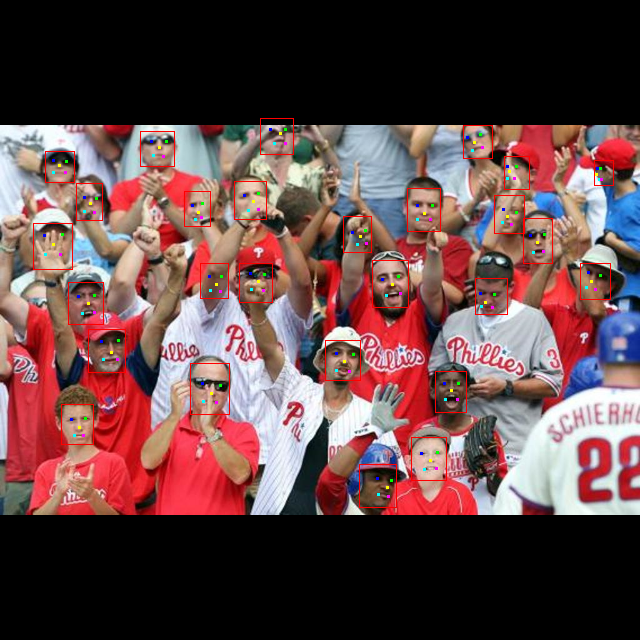

In [6]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")


img_path = "data/test.jpg"

img = read_img(img_path, img_size)
reversed_img = reverse(img, dims=1)
imgs = convert(atype, permutedims(reshape(reversed_img, (3, img_size, img_size, 1)), (3,2,1,4)))

# model = RetinaFace(dtype=atype)
# model = load_pth_model(model, save_dir * "Resnet50.jld"; dtype=atype)
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
c, b, l = predict_model(model, imgs; mode=mode) 

combined_pts = cat(b[1], l[1], dims=1)
img = convert(Array{Float32}, img .+ avg_img)
img ./= 255

draw_boxes_and_landmarks(img, combined_pts)